## INFS3208 Individual Project: NFL fantasy Helper

## Big Data Queries & Analytics

* I have done Type II: Big Data Queries.
* Keep in mind a limitation of the dataset is that it only provides records upto 2016, therefore assumed we are in 2016 and playing NFL fantasy football for 2017.

This project delves into the realm of fantasy football, where users pick NFL players to represent their team and compete with their friends. This project aims to provide users with more in-depth information and provide it visually. To learn more about the sport NFL and its rules, please click the following link. https://thefootballgirl.com/nfl-rules/

### Import necessary libraries for Project

In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import math
import pandas as pd
import seaborn as sns

## Read source files from HDFS and create RDDs

In [2]:
# Use spark
spark = SparkSession.builder \
    .appName("CSV Reader Example") \
    .getOrCreate()

hdfs_receivers_file_path = "hdfs://namenode:9000/Career_Stats_Receiving.csv"
hdfs_rushing_file_path = "hdfs://namenode:9000/Career_Stats_Rushing.csv"
hdfs_passing_file_path = "hdfs://namenode:9000/Career_Stats_Passing.csv"

df_rec = spark.read.csv(hdfs_receivers_file_path, header=True, escape='"', quote='"')
df_rus = spark.read.csv(hdfs_rushing_file_path, header=True, escape='"', quote='"')
df_pas = spark.read.csv(hdfs_passing_file_path, header=True, escape='"', quote='"')

In [3]:
rec_rdd_df = df_rec.select("Name", "Year", "Team", "Games Played", "Receptions", "Receiving Yards", "Yards Per Game", "Receiving TDs")
rus_rdd_df = df_rus.select("Name", "Year", "Team", "Games Played", "Rushing Attempts", "Rushing Yards", "Rushing Yards Per Game", "Rushing TDs")
pas_rdd_df = df_pas.select("Name", "Year", "Team", "Games Played", "Completion Percentage", "Passing Yards", "Passing Yards Per Game", "TD Passes")
# Convert the Receivers DataFrame to RDD
receivers_rdd = rec_rdd_df.rdd
# Convert the Rushing DataFrame to RDD
rushing_rdd = rus_rdd_df.rdd
# Convert the Passing DataFrame to RDD
passing_rdd = pas_rdd_df.rdd

In [4]:
# Show the first few elements of the RDD
for line in rushing_rdd.take(5):
    print("Row:", line)

Row: Row(Name='Evans, Fred', Year='1948', Team='Chicago Bears', Games Played='3', Rushing Attempts='10', Rushing Yards='15', Rushing Yards Per Game='5.0', Rushing TDs='0')
Row: Row(Name='Evans, Fred', Year='1948', Team='Chicago Rockets', Games Played='0', Rushing Attempts='--', Rushing Yards='--', Rushing Yards Per Game='--', Rushing TDs='--')
Row: Row(Name='Evans, Fred', Year='1947', Team='Chicago Rockets', Games Played='0', Rushing Attempts='--', Rushing Yards='--', Rushing Yards Per Game='--', Rushing TDs='--')
Row: Row(Name='Evans, Fred', Year='1947', Team='Buffalo Bills', Games Played='0', Rushing Attempts='--', Rushing Yards='--', Rushing Yards Per Game='--', Rushing TDs='--')
Row: Row(Name='Evans, Fred', Year='1946', Team='Cleveland Browns', Games Played='0', Rushing Attempts='--', Rushing Yards='--', Rushing Yards Per Game='--', Rushing TDs='--')


### Clean & pre-process Receivers data (WR)

In [5]:
# Clean NaN values and remove rows where 'Games played == 0'
receiving_yards_cleaned_rdd = receivers_rdd.filter(lambda row: row['Games Played'] != '0')
receiving_yards_cleaned_rdd = receiving_yards_cleaned_rdd.filter(lambda row: row['Receptions'] != '--' and row['Receiving Yards'] != '--')
receiving_yards_cleaned_rdd = receiving_yards_cleaned_rdd.filter(lambda row: row['Receiving Yards'] != '0')

In [6]:
receiving_yards_cleaned_rdd.take(5)

[Row(Name='Evans, Fred', Year='1948', Team='Chicago Bears', Games Played='3', Receptions='1', Receiving Yards='-2', Yards Per Game='-0.7', Receiving TDs='0'),
 Row(Name='Fowler, Bobby', Year='1985', Team='New Orleans Saints', Games Played='10', Receptions='5', Receiving Yards='43', Yards Per Game='4.3', Receiving TDs='0'),
 Row(Name='Johnson, Quinn', Year='2012', Team='Tennessee Titans', Games Played='16', Receptions='5', Receiving Yards='40', Yards Per Game='2.5', Receiving TDs='0'),
 Row(Name='Johnson, Quinn', Year='2011', Team='Tennessee Titans', Games Played='4', Receptions='3', Receiving Yards='30', Yards Per Game='7.5', Receiving TDs='0'),
 Row(Name='Johnson, Quinn', Year='2010', Team='Green Bay Packers', Games Played='11', Receptions='3', Receiving Yards='26', Yards Per Game='2.4', Receiving TDs='0')]

In [7]:
# Get the number of rows in the RDD
row_count_before = receivers_rdd.count()
row_count_after = receiving_yards_cleaned_rdd.count()

# Print the result
print(f"Number of rows in the RDD before cleaning rows: {row_count_before}")
print(f"Number of rows in the RDD after cleaning rows: {row_count_after}")

Number of rows in the RDD before cleaning rows: 18128
Number of rows in the RDD after cleaning rows: 13457


### Visualise the data distribution before and after data cleaning and pre-processing steps (WRs)

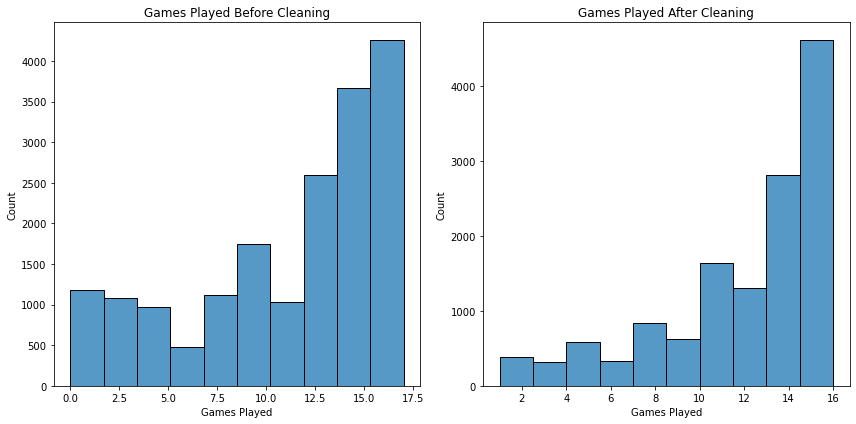

In [8]:
# Define the column names
columns = ['Name', 'Year', 'Team', 'Games Played', 'Receptions', 'Receiving Yards', 'Yards Per Game', 'Receiving TDs']

# Convert the RDDs into Pandas DataFrames
before_cleaning_df = pd.DataFrame(receivers_rdd.collect(), columns=columns)
after_cleaning_df = pd.DataFrame(receiving_yards_cleaned_rdd.collect(), columns=columns)

# Convert 'Games Played' to numeric
before_cleaning_df['Games Played'] = pd.to_numeric(before_cleaning_df['Games Played'], errors='coerce')
after_cleaning_df['Games Played'] = pd.to_numeric(after_cleaning_df['Games Played'], errors='coerce')

# Sort the data by 'Games Played'
before_cleaning_df_sorted = before_cleaning_df.sort_values(by='Games Played')
after_cleaning_df_sorted = after_cleaning_df.sort_values(by='Games Played')

# Plot 'Games Played' before and after cleaning 
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Before cleaning 
sns.histplot(before_cleaning_df_sorted['Games Played'], bins=10, kde=False, ax=axes[0])
axes[0].set_title("Games Played Before Cleaning")
axes[0].set_xlabel("Games Played")

# After cleaning 
sns.histplot(after_cleaning_df_sorted['Games Played'], bins=10, kde=False, ax=axes[1])
axes[1].set_title("Games Played After Cleaning")
axes[1].set_xlabel("Games Played")

plt.tight_layout()
plt.show()

### Clean & pre-process Rushing data (RB)

In [9]:
# Clean NaN values and remove rows where 'Games played == 0'
rushing_yards_cleaned_rdd = rushing_rdd.filter(lambda row: row['Games Played'] != '0')
rushing_yards_cleaned_rdd = rushing_yards_cleaned_rdd.filter(lambda row: row['Rushing Attempts'] != '--' and row['Rushing Yards'] != '--')
rushing_yards_cleaned_rdd = rushing_yards_cleaned_rdd.filter(lambda row: row['Rushing Yards'] != '0')

In [10]:
# Get the number of rows in the RDD
row_count_before = rushing_rdd.count()
row_count_after = rushing_yards_cleaned_rdd.count()

# Print the result
print(f"Number of rows in the RDD before cleaning rows: {row_count_before}")
print(f"Number of rows in the RDD after cleaning rows: {row_count_after}")

Number of rows in the RDD before cleaning rows: 17507
Number of rows in the RDD after cleaning rows: 11055


### Visualise the data distribution before and after data cleaning and pre-processing steps (RBs)

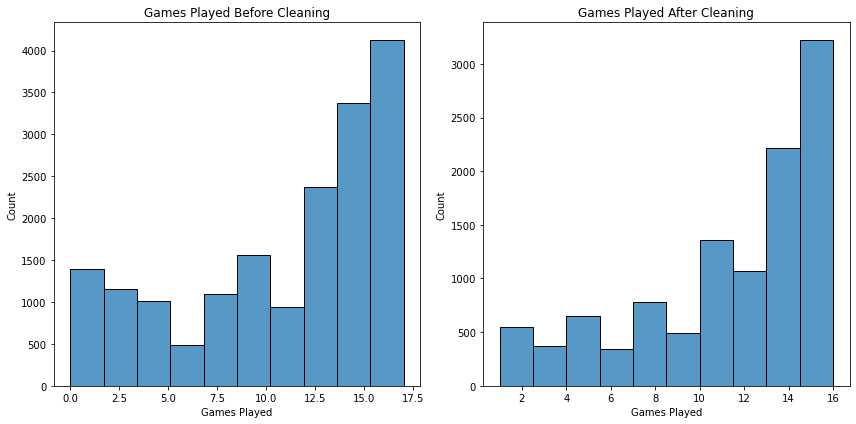

In [11]:
# Define the column names
columns = ["Name", "Year", "Team", "Games Played", "Rushing Attempts", "Rushing Yards", "Rushing Yards Per Game", "Rushing TDs"]

# Convert the RDDs into Pandas DataFrames
before_cleaning_df = pd.DataFrame(rushing_rdd.collect(), columns=columns)
after_cleaning_df = pd.DataFrame(rushing_yards_cleaned_rdd.collect(), columns=columns)

# Convert 'Games Played' to numeric
before_cleaning_df['Games Played'] = pd.to_numeric(before_cleaning_df['Games Played'], errors='coerce')
after_cleaning_df['Games Played'] = pd.to_numeric(after_cleaning_df['Games Played'], errors='coerce')

# Sort the data by 'Games Played'
before_cleaning_df_sorted = before_cleaning_df.sort_values(by='Games Played')
after_cleaning_df_sorted = after_cleaning_df.sort_values(by='Games Played')

# Plot 'Games Played' before and after cleaning 
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Before cleaning 
sns.histplot(before_cleaning_df_sorted['Games Played'], bins=10, kde=False, ax=axes[0])
axes[0].set_title("Games Played Before Cleaning")
axes[0].set_xlabel("Games Played")

# After cleaning 
sns.histplot(after_cleaning_df_sorted['Games Played'], bins=10, kde=False, ax=axes[1])
axes[1].set_title("Games Played After Cleaning")
axes[1].set_xlabel("Games Played")

plt.tight_layout()
plt.show()

### Clean & pre-process Passing data (QB)

In [12]:
# Clean NaN values and remove rows where 'Games played == 0'
passing_yards_cleaned_rdd = passing_rdd.filter(lambda row: row['Games Played'] != '0')
passing_yards_cleaned_rdd = passing_yards_cleaned_rdd.filter(lambda row: row['Completion Percentage'] != '--' and row['Passing Yards'] != '--')
passing_yards_cleaned_rdd = passing_yards_cleaned_rdd.filter(lambda row: row['Passing Yards'] != '0')

In [13]:
# Get the number of rows in the RDD
row_count_before = passing_rdd.count()
row_count_after = passing_yards_cleaned_rdd.count()

# Print the result
print(f"Number of rows in the RDD before cleaning rows: {row_count_before}")
print(f"Number of rows in the RDD after cleaning rows: {row_count_after}")

Number of rows in the RDD before cleaning rows: 8525
Number of rows in the RDD after cleaning rows: 3481


### Visualise the data distribution before and after data cleaning and pre-processing steps (QBs)

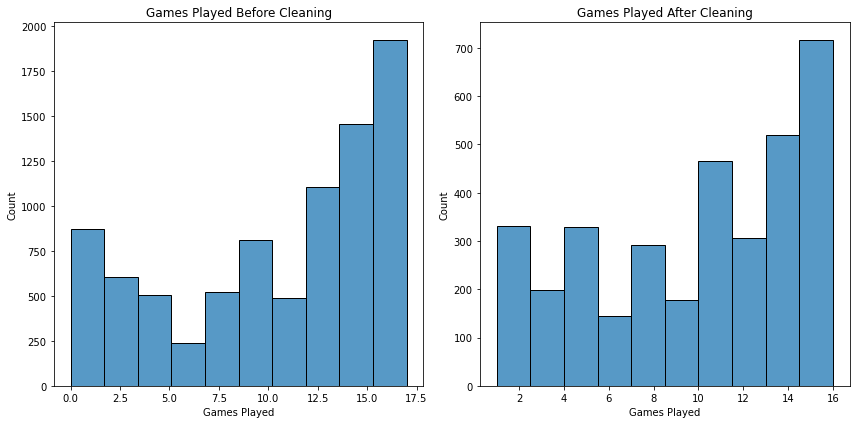

In [14]:
# Define the column names
columns = ["Name", "Year", "Team", "Games Played", "Completion Percentage", "Passing Yards", "Passing Yards Per Game", "TD Passes"]

# Convert the RDDs into Pandas DataFrames
before_cleaning_df = pd.DataFrame(passing_rdd.collect(), columns=columns)
after_cleaning_df = pd.DataFrame(passing_yards_cleaned_rdd.collect(), columns=columns)

# Convert 'Games Played' to numeric
before_cleaning_df['Games Played'] = pd.to_numeric(before_cleaning_df['Games Played'], errors='coerce')
after_cleaning_df['Games Played'] = pd.to_numeric(after_cleaning_df['Games Played'], errors='coerce')

# Sort the data by 'Games Played'
before_cleaning_df_sorted = before_cleaning_df.sort_values(by='Games Played')
after_cleaning_df_sorted = after_cleaning_df.sort_values(by='Games Played')

# Plot 'Games Played' before and after cleaning 
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Before cleaning 
sns.histplot(before_cleaning_df_sorted['Games Played'], bins=10, kde=False, ax=axes[0])
axes[0].set_title("Games Played Before Cleaning")
axes[0].set_xlabel("Games Played")

# After cleaning 
sns.histplot(after_cleaning_df_sorted['Games Played'], bins=10, kde=False, ax=axes[1])
axes[1].set_title("Games Played After Cleaning")
axes[1].set_xlabel("Games Played")

plt.tight_layout()
plt.show()

As you can see that from the distribution plots from before and after cleaning the data files for the WRs, RBs and QBs data, it can be identified that the count for 0 has been removes and the distribution is more skewed left which means the data will be more accurate for querying and analysis as it does not contain outliers or meaningless data. For example, if a player as 0 games played then their stats may affect the overall performance of the dataset and query results. 

## Satisfy the CRUD operations 

I do not need to update the following data source files, so therefore in order to meet the criteria and score the 1 mark for CRUD operations (update or delete). I have performed the following task to clone a source file and make some changes to it and save to HDFS.

In [15]:
from pyspark.sql.functions import when

# Create a DF for CRUD operations
crud_yards_df = spark.createDataFrame(receiving_yards_cleaned_rdd)

# Create a clone
df_clone = crud_yards_df

# Simulate UPDATE by changing values of Bengals players to have 100+ yards
updated_df = df_clone.withColumn(
    "Receiving Yards", 
    when(df_clone["Team"] == "Cincinnati Bengals", df_clone["Receiving Yards"] + 100).otherwise(df_clone["Receiving Yards"])
)

In [16]:
path = "hdfs://namenode:9000/updated_file.csv"
updated_df.write.csv(path, header=True, mode="overwrite")

## Big Data Queries using Spark SQL

### Big Data Query 1 - NFL team Receiving Yards vs Rushing Yards

In [17]:
# Convert dataframes as temporary views
rec_rdd_df.createOrReplaceTempView("receiving")
rus_rdd_df.createOrReplaceTempView("rushing")

team = 'New England Patriots'

# SQL query to filter and aggregate receiving yards
receiving_query = f"""
SELECT Year, SUM(CAST(`Receiving Yards` AS INT)) AS Receiving_Yards
FROM receiving
WHERE Team = '{team}' AND CAST(Year AS INT) >= 2000 
AND `Games Played` != '0' 
AND `Receptions` != '--' AND `Receiving Yards` != '--' AND `Receiving Yards` != '0'
GROUP BY Year
"""

# SQL query to filter and aggregate rushing yards 
rushing_query = f"""
SELECT Year, SUM(CAST(`Rushing Yards` AS INT)) AS Rushing_Yards
FROM rushing
WHERE Team = '{team}' AND CAST(Year AS INT) >= 2000 
AND `Games Played` != '0'
AND `Rushing Attempts` != '--' AND `Rushing Yards` != '--' AND `Rushing Yards` != '0'
GROUP BY Year
"""

# Execute the SQL queries
team_receiving_df = spark.sql(receiving_query)
team_rushing_df = spark.sql(rushing_query)

# Create temp views for the aggregated df to perform the JOIN
team_receiving_df.createOrReplaceTempView("bears_receiving")
team_rushing_df.createOrReplaceTempView("bears_rushing")

# Perform a JOIN operation on Year to compare rushing and receiving yards
comparison_query = """
SELECT b_rushing.Year, b_rushing.Rushing_Yards, b_receiving.Receiving_Yards
FROM bears_rushing b_rushing
JOIN bears_receiving b_receiving
ON b_rushing.Year = b_receiving.Year
ORDER BY b_rushing.Year
"""

# Execute the JOIN query
team_comparison_df = spark.sql(comparison_query)

# Collect data from the Spark df
yearly_yards = team_comparison_df.collect()

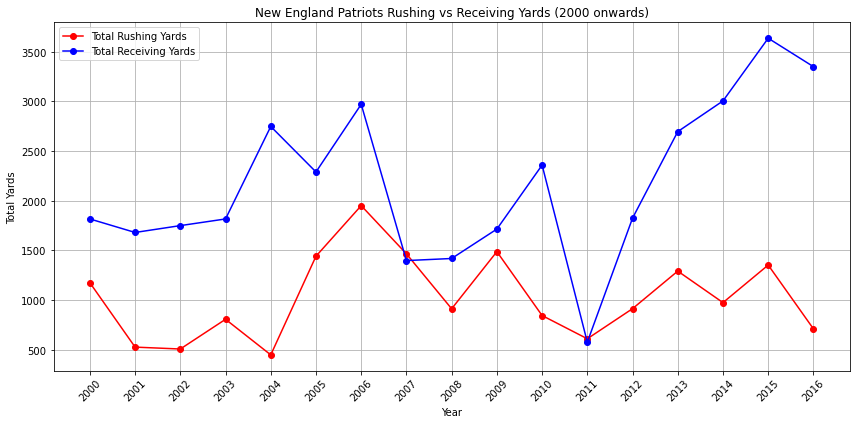

In [18]:
# Prepare data for plotting
years = [row['Year'] for row in yearly_yards]
rushing_yards = [row['Rushing_Yards'] for row in yearly_yards]
receiving_yards = [row['Receiving_Yards'] for row in yearly_yards]

# Plot results
plt.figure(figsize=(12, 6))

# Plot Rushing Yards
plt.plot(years, rushing_yards, marker='o', linestyle='-', color='r', label='Total Rushing Yards')

# Plot Receiving Yards
plt.plot(years, receiving_yards, marker='o', linestyle='-', color='b', label='Total Receiving Yards')

# Add title and labels
plt.title(f'{team} Rushing vs Receiving Yards (2000 onwards)')
plt.xlabel('Year')
plt.ylabel('Total Yards')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The figure above showcases the receiving yards and rushing yards for the Chicago Bears over the years from the 2000s. It can be seen that there is a correlation between receiving and rushing yards as when one is increased the other also increases. This is probably due to the team having a high offensive perfomance on their years. However, it can be identified that the Chicago Bears offense is prominently a heavy receiving team as of recent years. As especially in 2016 the total receiving yards was approximately 4000+ yards in comparison to total rushing yeards which adds up to less than 500 yards. In this scenario the NFL fantasy users will know that Chicago Bears receivers will dominate the offense and they should be picked ahead of their running backs (people who rush the ball). This tool will be highly valuable for NFL fantasy players as they can query the tool for different teams and understand their offensive outlook and whether they are pass heavy (more receiving yards) or run heavy (more rushing yards).

### Big Data Query 2 -  Top 10 players with most yards (Receiving, rushing or passing) in given year

In [19]:
# Load the passing data
pas_rdd_df.createOrReplaceTempView("passing")

In [20]:
year = 2016

# Combine the receiving, rushing, and passing yards into a single df using JOIN
combined_yards_query = f"""
SELECT 
    COALESCE(r.Name, ru.Name, p.Name) AS Name,
    COALESCE(CAST(r.`Receiving Yards` AS INT), 0) + 
    COALESCE(CAST(ru.`Rushing Yards` AS INT), 0) + 
    COALESCE(CAST(p.`Passing Yards` AS INT), 0) AS Total_Yards,
    COALESCE(CAST(r.`Receiving TDs` AS INT), 0) + 
    COALESCE(CAST(ru.`Rushing TDs` AS INT), 0) + 
    COALESCE(CAST(p.`TD passes` AS INT), 0) AS Total_TDs
FROM 
    (SELECT 
        Name, 
        Year, 
        `Receiving Yards`, 
        `Receiving TDs`, 
        `Games Played`, 
        `Receptions` 
     FROM receiving 
     WHERE CAST(Year AS INT) = {year} 
       AND `Games Played` != '0' 
       AND `Receptions` != '--' 
       AND `Receiving Yards` != '--' 
       AND `Receiving Yards` != '0') r
FULL OUTER JOIN 
    (SELECT 
        Name, 
        Year, 
        `Rushing Yards`, 
        `Rushing TDs`, 
        `Games Played`, 
        `Rushing Attempts` 
     FROM rushing 
     WHERE CAST(Year AS INT) = {year} 
       AND `Games Played` != '0' 
       AND `Rushing Attempts` != '--' 
       AND `Rushing Yards` != '--' 
       AND `Rushing Yards` != '0') ru 
ON r.Name = ru.Name
FULL OUTER JOIN 
    (SELECT 
        Name, 
        Year, 
        `Passing Yards`, 
        `TD passes`, 
        `Games Played`, 
        `Completion Percentage` 
     FROM passing 
     WHERE CAST(Year AS INT) = {year} 
       AND `Games Played` != '0' 
       AND `Completion Percentage` != '--' 
       AND `Passing Yards` != '--' 
       AND `Passing Yards` != '0') p 
ON r.Name = p.Name OR ru.Name = p.Name
"""

# Execute the combined yards query
combined_yards_df = spark.sql(combined_yards_query)

# Create a temp view
combined_yards_df.createOrReplaceTempView("combined_yards")

# Query top 10 players with the most total yards and total TDs
top_players_query = """
SELECT Name, 
       SUM(Total_Yards) AS Total_Yards,
       SUM(Total_TDs) AS Total_TDs
FROM combined_yards
GROUP BY Name
ORDER BY Total_Yards DESC
LIMIT 10
"""

# Execute the query to get top players
top_players_df = spark.sql(top_players_query)

# Print title
print(f"Top 10 Players with the Most Total Yards in {year}")

# Show results
top_players_df.show()

Top 10 Players with the Most Total Yards in 2016
+------------------+-----------+---------+
|              Name|Total_Yards|Total_TDs|
+------------------+-----------+---------+
|    Gordon, Melvin|       1416|       12|
|Michael, Christine|       1380|       16|
|     Ware, Spencer|       1368|        5|
|   Crowell, Isaiah|       1271|        7|
|      Gurley, Todd|       1212|        6|
|      Hyde, Carlos|       1151|        9|
|   Forsett, Justin|       1128|        3|
|     Powell, Bilal|       1110|        5|
|   Gabbert, Blaine|       1082|        7|
|       Forte, Matt|       1076|        8|
+------------------+-----------+---------+



The query to be able to return the top 10 players with the most yards (Receiving, Rushing or Passing) from the previous season would be pivotal for NFL Fantasy users that want to know which players are going into this season with good form. The tool works by the user being able to enter a year and it will return the top 10 players with the highest yards. This will give insights to the user to know which players got the most yards in the respective year. For example, in year 2016, Melvin Gordon had 1416 yards (rushing) and 12 total TDs which means they probably scored the most fantasy points in that year. So if I was a fantasy player for the upcoming season, Melvin Gordon would be high on my draft stock. 

### Big Data Query 3 - Player career comparison (For all positions) Years vs Total yards

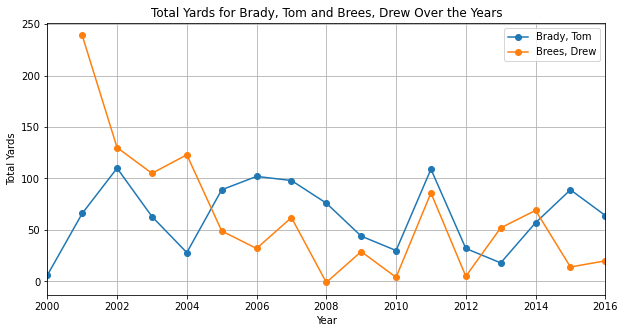

In [21]:
player1 = 'Brady, Tom'
player2 = 'Brees, Drew'

# Query for total yards for 2 different players
query = f"""
SELECT 
    coalesce(r.Name, ru.Name, p.Name) AS Name,
    coalesce(r.Year, ru.Year, p.Year) AS Year,
    coalesce(CAST(r.`Receiving Yards` AS INT), 0) + 
    coalesce(CAST(ru.`Rushing Yards` AS INT), 0) + 
    coalesce(CAST(p.`Passing Yards` AS INT), 0) AS Total_Yards
FROM 
    receiving r
FULL OUTER JOIN 
    rushing ru ON r.Name = ru.Name AND r.Year = ru.Year
FULL OUTER JOIN 
    passing p ON r.Name = p.Name AND r.Year = p.Year
WHERE 
    coalesce(r.Name, ru.Name, p.Name) IN ('{player1}', '{player2}')
    AND (r.`Games Played` != '0' OR ru.`Games Played` != '0' OR p.`Games Played` != '0')
    AND (r.`Receiving Yards` != '--' OR ru.`Rushing Yards` != '--' OR p.`Passing Yards` != '--')
    AND (r.`Receiving Yards` != '0' OR ru.`Rushing Yards` != '0' OR p.`Passing Yards` != '0')
ORDER BY Year
"""

# Execute the SQL query
result_df = spark.sql(query)

# Convert to Pandas df 
result_pd = result_df.toPandas()

result_pd['Year'] = result_pd['Year'].astype(int)

# Sort by Year
result_pd.sort_values(by='Year', inplace=True)

# Create a complete year range for careers
start_year = result_pd['Year'].min()
end_year = result_pd['Year'].max()
full_years = pd.DataFrame({'Year': range(start_year, end_year + 1)})

# Merge with total yards data
total_yards = result_pd.groupby(['Name', 'Year'])['Total_Yards'].sum().reset_index()
merged_df = full_years.merge(total_yards, on='Year', how='left').fillna(0)


plt.figure(figsize=(10, 5))

# Plot for each player
for player in merged_df['Name'].unique():
    player_data = merged_df[merged_df['Name'] == player]
    plt.plot(player_data['Year'], player_data['Total_Yards'], 
             marker='o', linestyle='-', label=player)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Total Yards')
plt.title(f'Total Yards for {player1} and {player2} Over the Years')
plt.xlim(start_year, end_year)  
plt.legend()
plt.grid()
plt.show()

The figure above shows Tom Brady vs Drew Brees performance over their careers. This query is great for users who are looking at comparing two players performances to make judgements between picking two players. For example, if I was a NFL fantasy player and for the upcoming season needed a QB, I would select Tom Brady over Drew Brees as he has been performing better as of late. This tool can compare any two players regardless of their positions, as it just compares the total yards produced by a player over their career. Great way to make a judgement between two players.

### Big Data Query 4 - Best WR and RB for each team in a year

In [22]:
# Team to query
team = 'Kansas City Chiefs'
# Year to query
year = 2016

# Query to return the top receiver and running back for a given year
query = f"""
-- Get the top receiver
SELECT 
    'Receiver' AS Player_Type,
    r.Name AS Player_Name,
    CAST(r.`Receiving Yards` AS INT) AS Yards,
    CAST(r.`Receiving TDs` AS INT) AS Touchdowns
FROM 
    receiving r
JOIN 
    (SELECT 
         Name,
         CAST(`Receiving Yards` AS INT) AS Max_Receiving_Yards
     FROM 
         receiving
     WHERE 
         Year = {year} AND Team = '{team}'
     ORDER BY 
         Max_Receiving_Yards DESC
     LIMIT 1) AS max_receiver 
ON 
    r.Name = max_receiver.Name AND CAST(r.`Receiving Yards` AS INT) = max_receiver.Max_Receiving_Yards

UNION ALL

-- Get the top running back
SELECT 
    'Running Back' AS Player_Type,
    ru.Name AS Player_Name,
    CAST(ru.`Rushing Yards` AS INT) AS Yards,
    CAST(ru.`Rushing TDs` AS INT) AS Touchdowns
FROM 
    rushing ru
JOIN 
    (SELECT 
         Name,
         CAST(`Rushing Yards` AS INT) AS Max_Rushing_Yards
     FROM 
         rushing
     WHERE 
         Year = {year} AND Team = '{team}'
     ORDER BY 
         Max_Rushing_Yards DESC
     LIMIT 1) AS max_rb 
ON 
    ru.Name = max_rb.Name AND CAST(ru.`Rushing Yards` AS INT) = max_rb.Max_Rushing_Yards
"""

# Execute the SQL query
result_df = spark.sql(query)

# Show the result
result_df.show()

+------------+-------------+-----+----------+
| Player_Type|  Player_Name|Yards|Touchdowns|
+------------+-------------+-----+----------+
|    Receiver| Hill, Tyreek|  593|         6|
|Running Back|Ware, Spencer|  921|         3|
+------------+-------------+-----+----------+



Query 4 demonstrates another way the user can get quick information on the best WR and RB options in a given team based off their past seasonal performances. In the example above, the query returns the top receiver and running back for the Kansas City Chiefs in 2016 alongside their respective yards and TDs. The example above returned Tyreek Hill and Spencer Ware. This tool provides the user with easy access to information that will provide them much needed insights when making decisions into which players to pick in regard to player form. 